**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# CS5495 - Tutorial 5
## CNNs - Feature Visualization

In this tutorial, you use feature visualization to examine the learned features in a CNN. 

First we need to initialize Python.  Run the below cell.

In [1]:
# setup
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100  # display larger images
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
pd.set_option('display.precision', 5)
import statsmodels.api as sm
import lime
import shap
from sklearn.model_selection import train_test_split
import os
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import torchvision

print(f"Using pytorch version: {torch.__version__}")

if (torch.cuda.is_available()):
    device = torch.device("cuda:0")
    print(f"Using: {torch.cuda.get_device_name(device)}")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
    print(f"Using: Apple MPS")
else:
    raise("no GPU available")


Using pytorch version: 2.8.0+cu128
Using: Tesla T4


## Helper functions
- These are helper functions from the lecture

In [3]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str): 
                    plt.title(titles % idx)
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

## Dog vs Cat Dataset

The task is to classify an image as having a cat or a dog. This dataset is from [Kaggle](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data).

In our dataset Class `0` is cat, and class `1` is dog.

First let's load the validation images. Make sure you have unzipped the validation and model files into your directory.

In [4]:
# the transform of the data for input into the network
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# class to store the dataset
class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform
        
    def __len__(self): return self.len
    
    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

In [6]:
# collect validation data file names
img_files = os.listdir('valid/')
len(img_files)
img_files = list(filter(lambda x: x != 'valid', img_files))
def valid_path(p): return f"valid/{p}"
img_files = list(map(valid_path, img_files))[::10] # subsample to make it faster

In [7]:
# load the dataset
valid_ds = CatDogDataset(img_files, test_transform)
valid_dl = DataLoader(valid_ds, batch_size=100)
classnames = ['cat', 'dog']
len(valid_ds), len(valid_dl)

(500, 5)

Now let's view a few samples

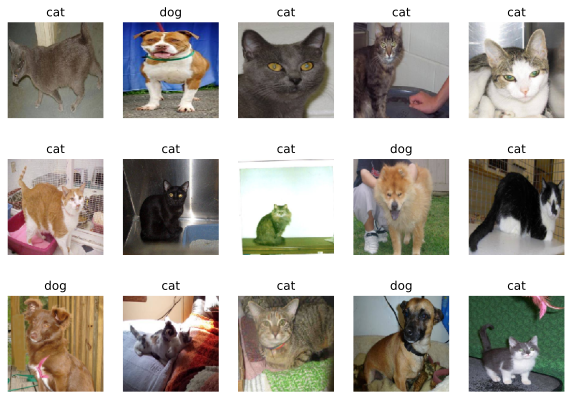

In [8]:
eg_imgs  = []
eg_names = []
for X,Y in valid_dl:
    for i in range(15):
        # transform the image from [-1,1] to [0,1]
        eg_imgs.append( (1+transpose(X[i], (1,2,0)))/2 )
        eg_names.append( classnames[Y[i]] )
    break
plt.figure(figsize=(10,7))
show_imgs(eg_imgs, titles=eg_names, nc=5)
plt.show()
plt.close()

# Deep CNNs

We have trained four Deep CNNs on the training set:

1. Model 1: 5 layers of convolutions, then global-average pooling and a linear classifier layer.
2. Model 2: 7 layers of convolutions, then global average pooling and a linear classifier layer.
3. Model 3: ResNet-18 (17 convolution layers), then global average pooling and a linear classifier layer. Trained from scratch.
4. Model 4: ResNet-18 (same as Model 3), but the network is initialized with pre-trained weights based on ImageNet.

Note that the global-average pooling takes the last convolution feature map (say C x H x W), and then averages over all the spatial nodes to obtain a (C x 1 x 1) feature vector. This is then used by the linear classifier layer.  Thus, the weights in the linear classifier layer will indicate which of the C feature channels was useful for the classification task.

Now we will load each model. If your GPU has limited memory, probably you should only load one model at a time.

## Model 1 (5 conv layers)

In [9]:
class CatAndDogNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.gap   = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(in_features= 128, out_features=2)
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv4(X))
        
        X = F.relu(self.conv5(X))

        X = self.gap(X)
        
        X = X.view(X.shape[0], -1)
        X = self.fc1(X)
        
        return X

In [10]:
# load model
model1 = CatAndDogNet4().to(device)
model1.load_state_dict(torch.load('models/model4-19.pth', map_location="cpu"))
model1.to(device).eval()
print(model1)

CatAndDogNet4(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)


## Model 2 (7 conv layers)

In [11]:
class CatAndDogNet6(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.conv7 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3, 3), padding=1)
        self.gap   = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features= 128, out_features=2)
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv4(X))
        
        X = F.relu(self.conv5(X))

        X = F.relu(self.conv6(X))

        X = F.relu(self.conv7(X))
        
        X = self.gap(X)
        
        X = X.view(X.shape[0], -1)
        X = self.fc1(X)        
        return X

In [12]:
# load model
model2 = CatAndDogNet6().to(device)
model2.load_state_dict(torch.load('models/model6-19.pth', map_location="cpu"))
model2.to(device).eval()
print(model2)

CatAndDogNet6(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)


## Model 3 (ResNet-18, from scratch)

In [13]:
model3 = models.resnet18().to(device)
in_feats = model3.fc.in_features
model3.fc = nn.Linear(in_feats, 2)
model3.load_state_dict(torch.load('models/model8-17.pth', map_location="cpu"))
model3.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model 4 (ResNet-18, pretrained on ImageNet)

In [14]:
model4 = models.resnet18().to(device)
in_feats = model4.fc.in_features
model4.fc = nn.Linear(in_feats, 2)
model4.load_state_dict(torch.load('models/model7-18.pth', map_location="cpu"))
model4.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluation
Now we will evaluate the models. First consolidate them.

In [15]:
all_models = {
    'CNN5': model1, 
    'CNN7': model2, 
    'ResNet18': model3,
    'ResNet18p': model4
}
modelnames = all_models.keys()

Evaluate each  model on the validation data.

In [16]:
# Evaluation
correct = {}
total = {}
for myname,mymodel in all_models.items():    
    mymodel.to(device).eval()
    correct[myname] = 0
    total[myname] = 0
    
with torch.no_grad():
    # for each validation batch
    for data, targets in valid_dl:
        print('.', end='', flush=True)                
        data, targets = data.to(device), targets.to(device)

        # test each model
        for myname,mymodel in all_models.items():    
            mymodel.to(device).eval()
            correct[myname] = 0
            total[myname] = 0
        
            outputs = mymodel(data)
            _, predicted = torch.max(outputs.data, 1)
            total[myname] += targets.size(0)
            correct[myname] += (predicted == targets).sum().item()

print("")
for myname in all_models.keys():    
    print(myname + f' Accuracy on valid set: {100 * correct[myname] / total[myname]:.2f}%')

.....
CNN5 Accuracy on valid set: 84.00%
CNN7 Accuracy on valid set: 77.00%
ResNet18 Accuracy on valid set: 90.00%
ResNet18p Accuracy on valid set: 97.00%


# Feature Visualization

Now, examine the features of each model using the feature visualization method. 

You can use the `lucent` toolbox. If it is not installed on your system, use the following command: `pip install torch-lucent`
On the CS JupyterLab, you can run this by opening a terminal tab. In Jupyter notebook, you can run the following "magic" command `!pip install torch-lucent`

In [17]:
!pip install torch-lucent

  Using cached torch_lucent-0.1.8-py3-none-any.whl.metadata (6.1 kB)
  Using cached kornia-0.4.1-py2.py3-none-any.whl.metadata (11 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached pytest-8.4.2-py3-none-any.whl.metadata (7.7 kB)
  Using cached pytest_mock-3.15.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached coverage-7.11.0-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl.metadata (9.0 kB)
  Using cached coveralls-4.0.1-py3-none-any.whl.metadata (5.3 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached iniconfig-2.3.0-py3-none-any.whl.metadata (2.5 kB)
Using cached torch_lucent-0.1.8-py3-none-any.whl (46 kB)
Using cached kornia-0.4.1-py2.py3-none-any.whl (225 kB)
Using cached coverage-7.11.0-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl (250 kB)
Using cached coveralls-4.0.1-py3-none-any.whl (13 kB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached pytest-8.4.2-py3

## Features in the Last Conv Layer 

Perform feature visualization on the last convolutional layer of the networks.  Since there are a lot of features, one suggestion is to focus on those features that were more useful for the classifier (e.g., looking at the features with largest effects).

In [18]:
# 3.1 Features in the Last Conv Layer (data-driven top patches — lecture-style) with progress bars
import torch
import numpy as np
from tqdm import tqdm

def get_activation_hook(store):
    def hook(module, input, output):
        store['act'] = output.detach()
    return hook

def collect_top_patches_from_loader(model, layer, channel, dataloader, topk=6, patch_sz=96, max_images=2000, device=torch.device('cpu')):
    model.eval()
    activations = []
    seen = 0
    hook = None
    try:
        try:
            total_batches = len(dataloader)
        except Exception:
            total_batches = None
        it = tqdm(dataloader, desc=f"Scanning data (ch={channel})", total=total_batches)
        for X, Y in it:
            if seen >= max_images:
                break
            X = X.to(device)
            st = {}
            hook = layer.register_forward_hook(get_activation_hook(st))
            with torch.no_grad():
                _ = model(X)
            hook.remove()
            act = st.get('act')
            if act is None:
                continue
            actc = act[:, channel, :, :].cpu().numpy()
            B, H, W = actc.shape
            X_cpu = X.detach().cpu()
            for b in range(B):
                flat = actc[b].ravel()
                topn = min(3, flat.size)
                if topn == 0:
                    continue
                ids = np.argsort(flat)[-topn:]
                for idx in ids:
                    hi = int(idx // W); wi = int(idx % W)
                    score = float(flat[idx])
                    activations.append((score, X_cpu[b].clone(), hi, wi, H, W))
            seen += B
            if len(activations) > topk * 20:
                activations = sorted(activations, key=lambda x: -x[0])[:topk*20]
            it.set_postfix({'seen_imgs': seen, 'collected': len(activations)})
        try:
            it.close()
        except:
            pass
    finally:
        try:
            if hook is not None:
                hook.remove()
        except:
            pass
    activations = sorted(activations, key=lambda x: -x[0])[:topk]
    patches = []
    for score, img_t, hi, wi, H, W in activations:
        Hin = img_t.shape[1]; Win = img_t.shape[2]
        cy = int((hi + 0.5) * (Hin / H)); cx = int((wi + 0.5) * (Win / W))
        half = patch_sz // 2
        y0 = max(0, cy - half); y1 = min(Hin, cy + half)
        x0 = max(0, cx - half); x1 = min(Win, cx + half)
        patch = img_t[:, y0:y1, x0:x1]
        patch_np = (patch * 0.5 + 0.5).permute(1,2,0).numpy()
        ph, pw = patch_np.shape[0], patch_np.shape[1]
        if ph != patch_sz or pw != patch_sz:
            new = np.zeros((patch_sz, patch_sz, 3), dtype=patch_np.dtype)
            new[:ph, :pw, :] = patch_np
            patch_np = new
        patches.append(patch_np)
    return patches

from tqdm import tqdm as tq
channels_to_show = [0, 5, 10, 20]
all_opt_patches = []
all_titles = []

for name, m in tq(list(all_models.items()), desc="Models"):
    if hasattr(m, 'conv7'):
        layer = m.conv7
    elif hasattr(m, 'conv5'):
        layer = m.conv5
    else:
        try:
            layer = m.layer4[-1].conv2
        except Exception:
            layer = m
    try:
        model_device = next(m.parameters()).device
    except StopIteration:
        model_device = torch.device('cpu')
    try:
        st = {}; h = layer.register_forward_hook(get_activation_hook(st))
        dummy = torch.zeros(1,3,64,64, device=model_device)
        with torch.no_grad():
            _ = m(dummy)
        h.remove()
        C = st['act'].shape[1]
    except Exception:
        C = 128
    sel = [ch for ch in channels_to_show if ch < C]
    for ch in tq(sel, desc=f"{name} channels", leave=False):
        try:
            patches = collect_top_patches_from_loader(m, layer, ch, valid_dl, topk=6, patch_sz=96, max_images=800, device=model_device)
            if patches:
                all_opt_patches.extend(patches)
                all_titles.extend([f"{name} ch{ch} (patch{i})" for i in range(len(patches))])
        except Exception as e:
            print(f"Patch collection failed for {name} ch{ch}: {e}")

if all_opt_patches:
    show_imgs(all_opt_patches, nc=6, titles=all_titles, figsize_per_image=(2.5,2.5))
else:
    print("No patches found/collected.")


CNN5 channels:   0%|          | 0/4 [00:00<?, ?it/s]

Scanning data (ch=0):   0%|          | 0/5 [00:00<?, ?it/s]

Scanning data (ch=0):   0%|          | 0/5 [00:14<?, ?it/s, seen_imgs=100, collected=120]

Scanning data (ch=0):  20%|██        | 1/5 [00:14<00:56, 14.21s/it, seen_imgs=100, collected=120]

Scanning data (ch=0):  20%|██        | 1/5 [00:28<00:56, 14.21s/it, seen_imgs=200, collected=120]

Scanning data (ch=0):  40%|████      | 2/5 [00:28<00:42, 14.19s/it, seen_imgs=200, collected=120]

Scanning data (ch=0):  40%|████      | 2/5 [00:42<00:42, 14.19s/it, seen_imgs=300, collected=120]

Scanning data (ch=0):  60%|██████    | 3/5 [00:42<00:28, 14.18s/it, seen_imgs=300, collected=120]

Scanning data (ch=0):  60%|██████    | 3/5 [00:56<00:28, 14.18s/it, seen_imgs=400, collected=120]

Scanning data (ch=0):  80%|████████  | 4/5 [00:56<00:14, 14.23s/it, seen_imgs=400, collected=120]

Scanning data (ch=0):  80%|████████  | 4/5 [01:11<00:14, 14.23s/it, seen_imgs=500, collected=120]

Sc

TypeError: show_imgs() got an unexpected keyword argument 'figsize_per_image'

## Summary of Feature Visualization

Provide a summary of your interpretation of the models using feature visualization. Some interesting questions to consider...
- Considering the four models, what types are features are extracted from the last conv layers?
- How do the features change with the depth of the model?
- How are the features different for models learned from scratch versus using a pre-trained initialization?
- how does the feature visualization help to understand the differences in validation set accuracy?


- **INSERT YOUR ANSWER HERE**
- ...
- ...

# Art!

Now explore the feature visualizations of other parts of the network. See if you can find some interesting textures or patterns. What do they resemble?

In [19]:
# 4. Art! — show conv1 kernels and top patches for early layers (lecture-style) with progress indicators
import torch, numpy as np
from tqdm import tqdm

def visualize_conv_weights(conv_layer, max_show=16):
    W = conv_layer.weight.detach().cpu().numpy()
    imgs = []; titles = []
    out_ch = W.shape[0]
    for i in range(min(max_show, out_ch)):
        w = W[i]
        w_min, w_max = w.min(), w.max()
        w_img = (w - w_min) / (w_max - w_min + 1e-8)
        w_img = np.transpose(w_img, (1,2,0))
        imgs.append(w_img); titles.append(f"w_ch{i}")
    return imgs, titles

target_model = None; target_name = None
for name, m in all_models.items():
    if hasattr(m, 'conv1') and hasattr(m, 'conv2'):
        target_model = m; target_name = name; break
if target_model is None:
    target_name = list(all_models.keys())[0]; target_model = all_models[target_name]

if hasattr(target_model, 'conv1'):
    w_imgs, w_titles = visualize_conv_weights(target_model.conv1, max_show=12)
    if w_imgs:
        show_imgs(w_imgs, nc=4, titles=w_titles, figsize_per_image=(2,2))

layer_list = []
if hasattr(target_model, 'conv1') and hasattr(target_model, 'conv2'):
    layer_list = [('conv1', target_model.conv1), ('conv2', target_model.conv2)]
else:
    try:
        layer_list = [('layer1.0.conv1', target_model.layer1[0].conv1), ('layer1.0.conv2', target_model.layer1[0].conv2)]
    except Exception:
        layer_list = []

patch_images = []; patch_titles = []
for lname, layer in tqdm(layer_list, desc="Early layers"):
    try:
        try:
            st = {}; h = layer.register_forward_hook(get_activation_hook(st))
            _ = target_model(torch.zeros(1,3,64,64))
            h.remove()
            C = st['act'].shape[1]
        except Exception:
            C = 32
        channels = list(range(min(8, C)))
        for ch in tqdm(channels, desc=f"{lname} channels", leave=False):
            patches = collect_top_patches_from_loader(target_model, layer, ch, valid_dl, topk=4, patch_sz=64, max_images=600, device=torch.device('cpu'))
            for i,p in enumerate(patches):
                patch_images.append(p); patch_titles.append(f"{lname} ch{ch} p{i}")
    except Exception as e:
        print('Error collecting patches for', lname, e)

if patch_images:
    show_imgs(patch_images, nc=6, titles=patch_titles, figsize_per_image=(2,2))
else:
    print("No early-layer patches found.")


TypeError: show_imgs() got an unexpected keyword argument 'figsize_per_image'